In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import datetime
import joblib
from flask import Flask, request, jsonify

In [2]:
ticker = 'AAPL' # Example: Apple Inc.
data = yf.download(ticker, start="2019-01-01", end=datetime.date.today())

print("✅ Data fetched successfully!")
print(data.head())

/tmp/ipython-input-2723703223.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2019-01-01", end=datetime.date.today())
[*********************100%***********************]  1 of 1 completed

✅ Data fetched successfully!
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2019-01-02  37.538826  37.759896  36.661683  36.818571  148158800
2019-01-03  33.799683  34.638791  33.754518  34.225178  365248800
2019-01-04  35.242550  35.311487  34.182375  34.355901  234428400
2019-01-07  35.164124  35.378063  34.681577  35.347160  219111200
2019-01-08  35.834454  36.088803  35.304366  35.551581  164101200


In [3]:
data = data[['Open', 'High', 'Low', 'Volume', 'Close']].dropna()

# Shift 'Close' to create the prediction target (next day's close)
data['Target'] = data['Close'].shift(-1)

# Drop the last row (NaN target)
data = data[:-1]

X = data[['Open', 'High', 'Low', 'Volume']]
y = data['Target']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [4]:
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [5]:
joblib.dump(model, "stock_model.pkl")

['stock_model.pkl']

In [6]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"📈 MSE: {mse:.2f}")
print(f"📊 R² Score: {r2:.2f}")

📈 MSE: 18.15
📊 R² Score: 0.95


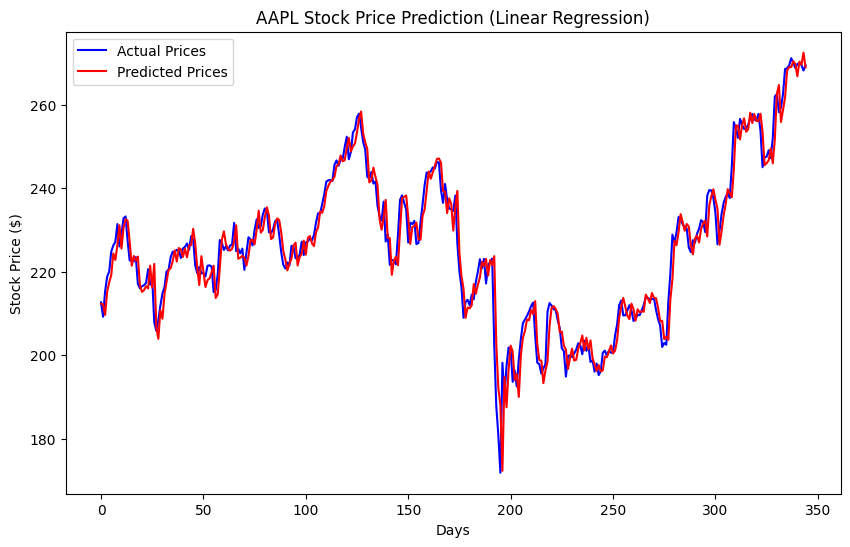

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Prices', color='blue')
plt.plot(y_pred, label='Predicted Prices', color='red')
plt.title(f'{ticker} Stock Price Prediction (Linear Regression)')
plt.xlabel('Days')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.show()

In [8]:
app = Flask(__name__)
model = joblib.load("stock_model.pkl")

@app.route('/')
def home():
    return "Stock Price Prediction API is running 🚀"

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    # Expected JSON input: {"Open": 190.3, "High": 191.2, "Low": 189.5, "Volume": 40000000}
    input_features = np.array([[data['Open'], data['High'], data['Low'], data['Volume']]])
    prediction = model.predict(input_features)[0]
    return jsonify({'predicted_price': round(float(prediction), 2)})

